In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("data/02-processed/preprocessed_anime_data.csv")

df.head()

,anime_id,title,type,episodes,duration,genres,start_date,end_date,status,is_shounen,is_slice_of_life,start_year,end_year,aired_days
0,3009,Tiger Mask,tv,105,23,Combat Sports;Drama;Shounen;Sports,1969-10-02,1971-09-30,finished_airing,True,False,1969.0,1971.0,729.0
1,2830,Chibikko Remi to Meiken Kapi,movie,1,81,Adventure;Drama,1970-03-17,1970-03-17,finished_airing,False,False,1970.0,1970.0,1.0
2,8899,Kaitei Shounen Marine,tv,65,25,Action;Adventure;Kids;Sci-Fi,1969-01-13,1971-09-02,finished_airing,False,False,1969.0,1971.0,963.0
3,12789,Yasashii Lion,movie,1,27,Award Winning;Fantasy;Kids;Music,1970-03-21,1970-03-21,finished_airing,False,False,1970.0,1970.0,1.0
4,17445,Kyojin no Hoshi: Dai League Ball,movie,1,70,Drama;Sports;Team Sports,1970-03-21,1970-03-21,finished_airing,False,False,1970.0,1970.0,1.0


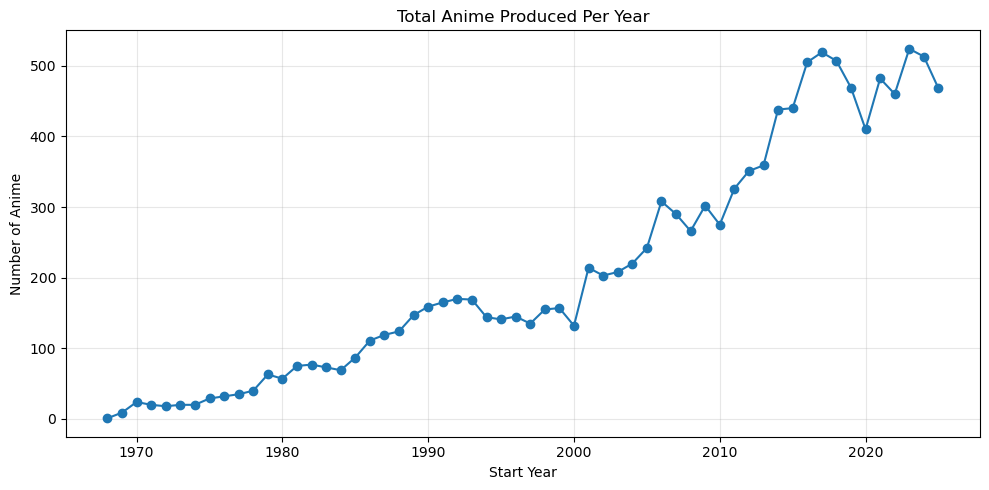

In [7]:
year_counts = (
    df
    .dropna(subset=["start_year"])
    .assign(start_year=lambda df: df["start_year"].astype(int))
    .query("start_year < 2026")
    .groupby("start_year")
    .size()
    .sort_index()
)

plt.figure(figsize=(10, 5))
plt.plot(year_counts.index, year_counts.values, marker="o")
plt.title("Total Anime Produced Per Year")
plt.xlabel("Start Year")
plt.ylabel("Number of Anime")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

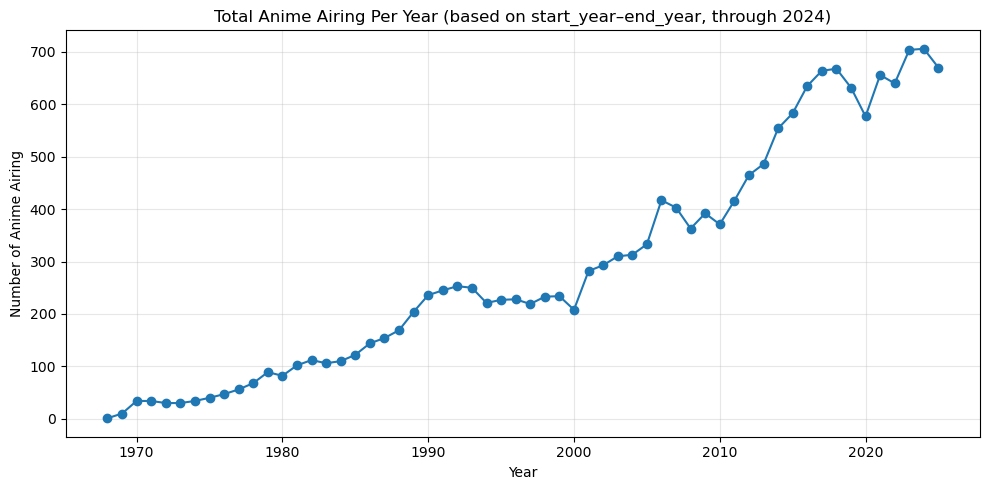

In [11]:

og_df = pd.read_csv("data/02-processed/preprocessed_anime_data.csv")
df = og_df.copy()

# Convert to integer years (nullable int)
df["start_year"] = df["start_year"].astype("Int64")
df["end_year"]   = df["end_year"].astype("Int64")

# Exclude 2026+ from the *timeline* (and cap currently-airing shows at 2024)
LAST_YEAR = 2025

df = df[df["start_year"].notna() & (df["start_year"] <= LAST_YEAR)].copy()
df["end_year"] = df["end_year"].fillna(LAST_YEAR).clip(upper=LAST_YEAR)

# Keep only valid ranges
df = df[df["end_year"] >= df["start_year"]].copy()

# Expand each anime into all years it was airing (inclusive), then count per year
df_years = (
    df.assign(year=df.apply(lambda r: list(range(int(r["start_year"]), int(r["end_year"]) + 1)), axis=1))
      .explode("year")
)

airing_counts = df_years.groupby("year").size().sort_index()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(airing_counts.index, airing_counts.values, marker="o")
plt.title("Total Anime Airing Per Year (based on start_year–end_year, through 2024)")
plt.xlabel("Year")
plt.ylabel("Number of Anime Airing")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

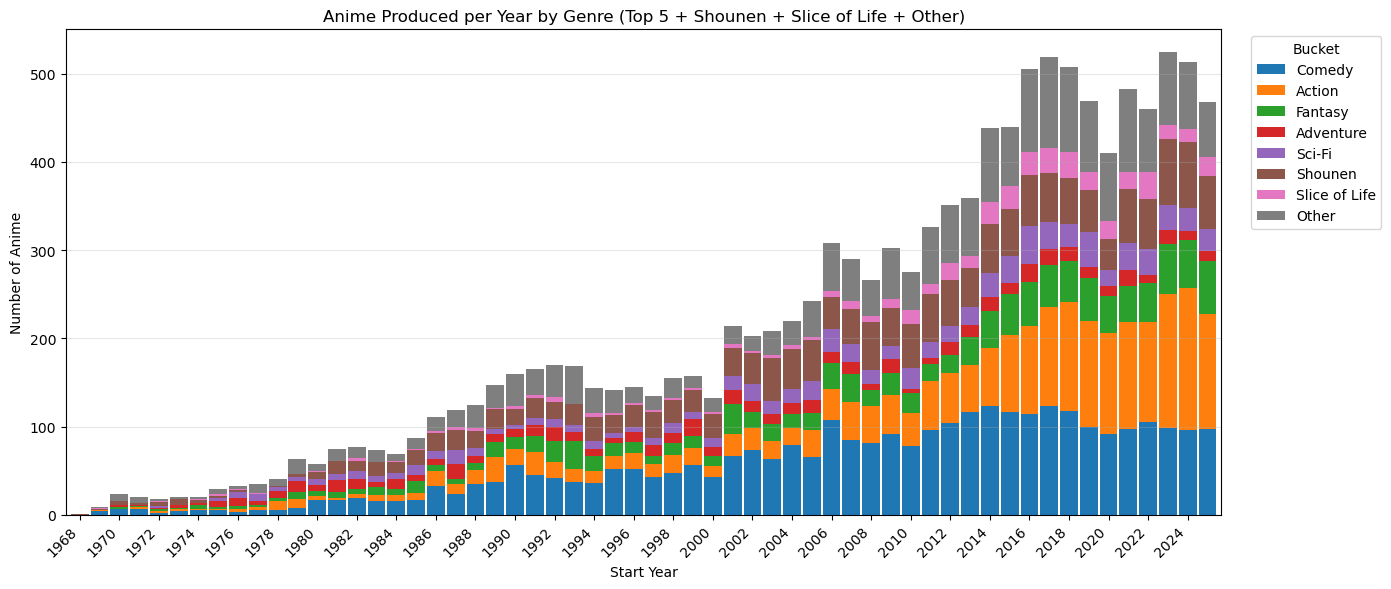

Top 5 genres used: ['Comedy', 'Action', 'Fantasy', 'Adventure', 'Sci-Fi']


In [12]:
df = og_df.copy()

# Exclude 2026+
df = df.dropna(subset=["start_year"]).copy()
df["start_year"] = df["start_year"].astype(int)
df = df[df["start_year"] < 2026].copy()

# top 5 genres overall (exclude Slice of Life + Shounen since they get their own bins)
all_genres = (
    df["genres"].dropna()
      .str.split(";")
      .explode()
      .str.strip()
      .replace("", np.nan)
      .dropna()
)
top5 = (
    all_genres[~all_genres.isin(["Slice of Life", "Shounen"])]
    .value_counts()
    .head(5)
    .index
    .tolist()
)

# --- assign each anime to exactly one bucket (priority: Shounen, Slice of Life, top5, Other) ---
def bucket_genre(row):
    if row.get("is_shounen", False):
        return "Shounen"
    if row.get("is_slice_of_life", False):
        return "Slice of Life"

    g = row.get("genres", None)
    if pd.isna(g):
        return "Other"
    gset = {x.strip() for x in str(g).split(";") if x.strip()}
    for genre in top5:
        if genre in gset:
            return genre
    return "Other"

df["genre_bucket"] = df.apply(bucket_genre, axis=1)

counts = (
    df.groupby(["start_year", "genre_bucket"])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

order = top5 + ["Shounen", "Slice of Life", "Other"]
counts = counts.reindex(columns=order, fill_value=0)

# --- plot ---
fig, ax = plt.subplots(figsize=(14, 6))
counts.plot(kind="bar", stacked=True, ax=ax, width=0.9)

ax.set_title("Anime Produced per Year by Genre (Top 5 + Shounen + Slice of Life + Other)")
ax.set_xlabel("Start Year")
ax.set_ylabel("Number of Anime")
ax.grid(axis="y", alpha=0.3)

years = counts.index.to_numpy()
tick_every = max(1, len(years) // 20)
ax.set_xticks(np.arange(0, len(years), tick_every))
ax.set_xticklabels(years[::tick_every], rotation=45, ha="right")

ax.legend(title="Bucket", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

print("Top 5 genres used:", top5)